In [ ]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd

Dataset

In [ ]:
!mkdir ~/.kaggle

In [ ]:
mv /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n apikey -v ~/.kaggle/kaggle.json

- apikey is now set to: /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [00:51<00:00, 83.6MB/s]
100% 4.16G/4.16G [00:51<00:00, 86.8MB/s]


In [ ]:
# Unzip dataset
path_to_zip_file = "brats20-dataset-training-validation.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall("brats20-dataset-training-validation")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Absolute path of the incorrectly named file
old_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# Renaming the file
try:
    os.rename(old_name, new_name)
    print("The file has been successfully renamed")
except FileNotFoundError:
    print("Maybe you have already renamed the file or the file is not misspelled on the dataset anymore")

The file has been successfully renamed


Understanding the data

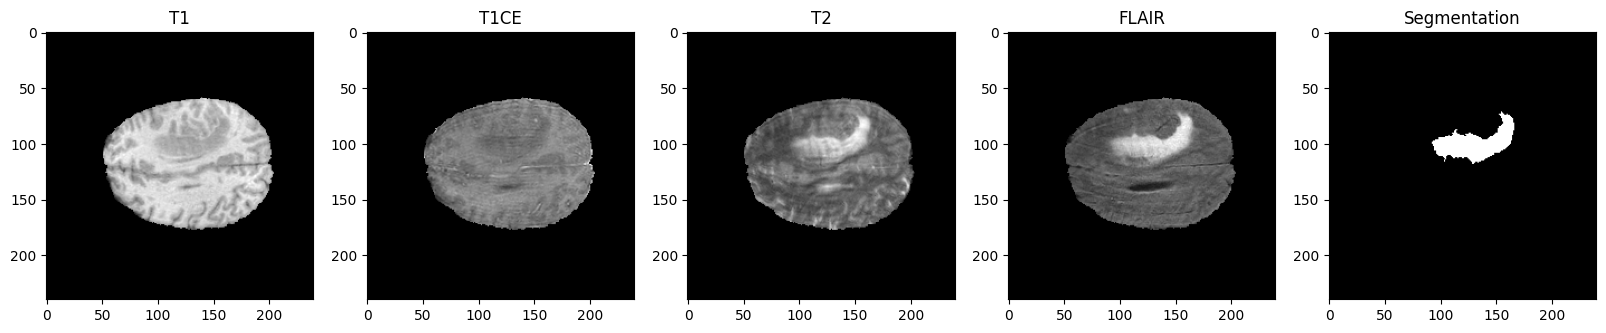

In [ ]:
# Visualize the data
sample_path = 'brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_'

# Load the 4 MRI modalities and the segmentation located in the patient's path using the nibabel library
t1_img=nib.load(sample_path + 't1.nii')
t1ce_img=nib.load(sample_path + 't1ce.nii')
t2_img=nib.load(sample_path + 't2.nii')
flair_img=nib.load(sample_path + 'flair.nii')
seg_img=nib.load(sample_path + 'seg.nii')

# Get the image data
t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()

# Plot 100th slice of the 4 RMI modalities and the segmentation
slice_nb = 100

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
plt.show()

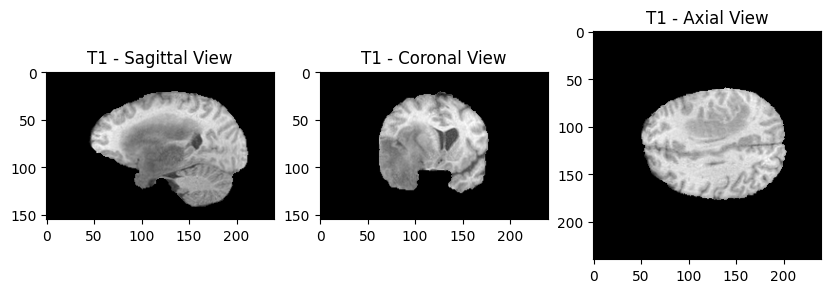

In [ ]:
# Plot 3 modalities
slice_nb = 100

fig, axs2 = plt.subplots(1, 3, figsize=(10,10))
axs2[0].imshow(rotate(t1_data[slice_nb,:,:], 90, resize=True), cmap="gray")
axs2[0].set_title('T1 - Sagittal View')

axs2[1].imshow(rotate(t1_data[:,slice_nb,:], 90, resize=True), cmap="gray")
axs2[1].set_title('T1 - Coronal View')

axs2[2].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T1 - Axial View')

plt.show()

From UNet tutorial: use the (60:135) range otherwise visualizations don't contain enough information

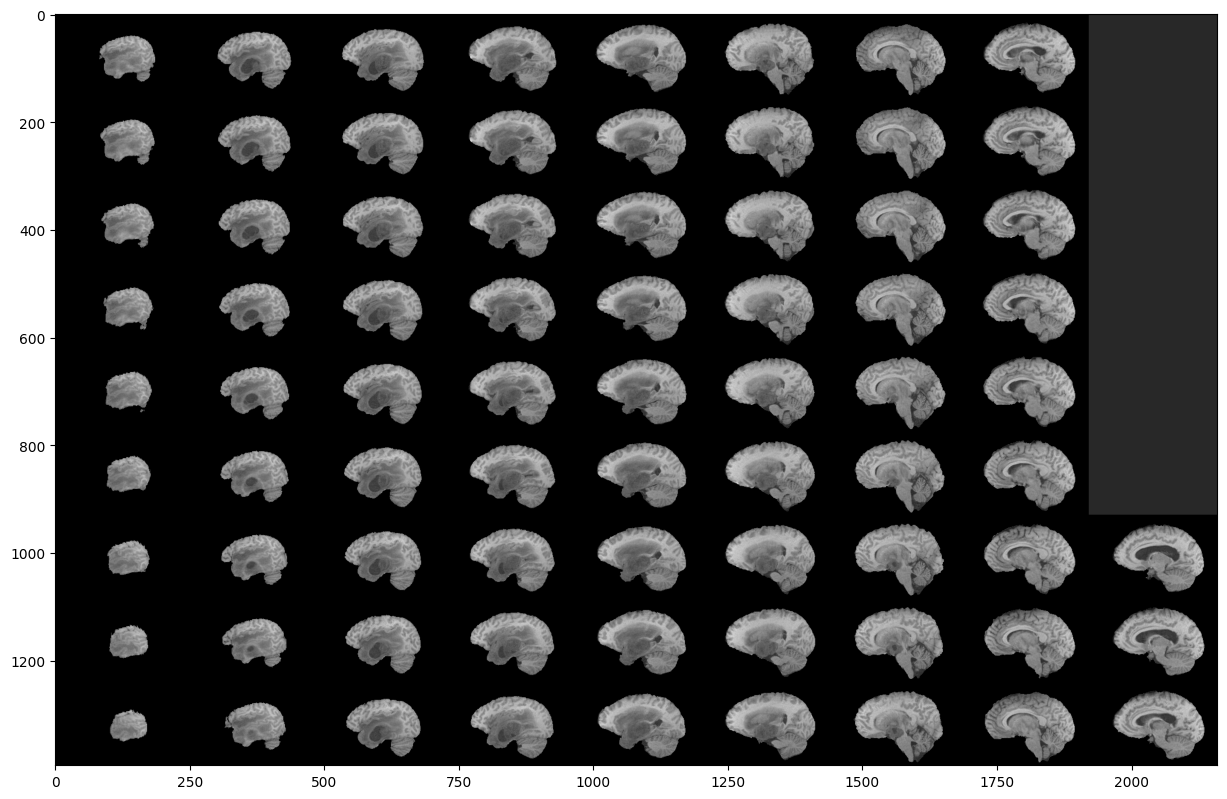

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[60:135,:,:]), 90, resize=True), cmap ='gray')

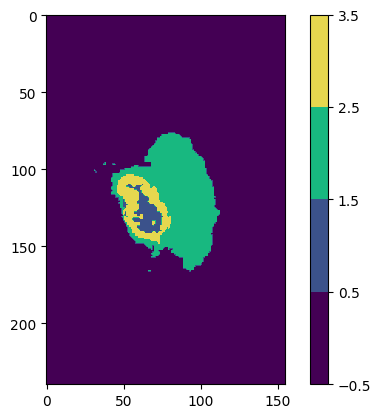

In [ ]:
# Plot a segmantation
some_seg_img = nib.load("brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii").get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()

In [ ]:
data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
seg_samples = [os.path.join(data_path, sample, f"{sample}_seg.nii") for sample in os.listdir(data_path) if not sample.endswith('.csv')]
# change BraTS20 training 355
saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))

    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")

Maximum number of values in all segmentation images: 4
Values: [0. 1. 2. 4.]


We are predicting 4 classes of brain tumors:
- **0** : Not Tumor (NT) which means Healthy Zone or Background
- **1** : Necrotic and Non-Enhancing Tumor (NCR + NET)
- **2** : Peritumoral Edema (ED)
- **3** : Enhancing Tumor (ET)

In [ ]:
values, counts = np.unique(some_seg_img, return_counts=True)
print(counts)

[8716021   15443  168794   27742]


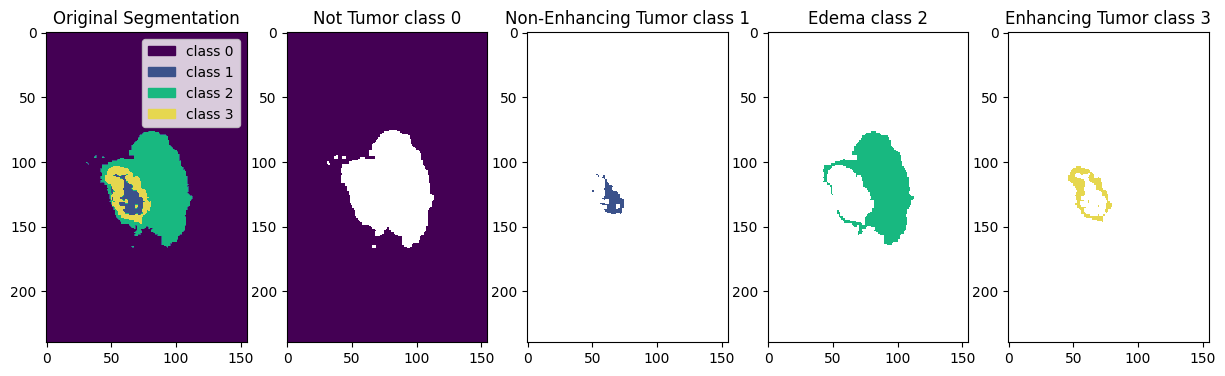

In [ ]:
# Deletion of class 0 because background is not needed
seg_0 = some_seg_img.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = some_seg_img.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = some_seg_img.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_3 = some_seg_img.copy()
seg_3[seg_3 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 3']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs3 = plt.subplots(1, 5, figsize=(15, 15))

axs3[0].imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
axs3[0].set_title('Original Segmentation')
axs3[0].legend(handles=legend, loc='upper right')

axs3[1].imshow(seg_0[100,:,:], cmap=cmap, norm=norm)
axs3[1].set_title('Not Tumor class 0')

axs3[2].imshow(seg_1[100,:,:], cmap=cmap, norm=norm)
axs3[2].set_title('Non-Enhancing Tumor class 1')

axs3[3].imshow(seg_2[100,:,:], cmap=cmap, norm=norm)
axs3[3].set_title('Edema class 2')

axs3[4].imshow(seg_3[100,:,:], cmap=cmap, norm=norm)
axs3[4].set_title('Enhancing Tumor class 3')

plt.show()

In [ ]:
# Define selected slices range
VOLUME_START_AT = 60
VOLUME_SLICES = 75
# VOLUME_SLICES = 150

### Preprocess data for training

In [ ]:
# Specify path of our BraTS2020 directory
data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(data_path)
print("Number of samples:", len(samples))

Number of samples: 371


In [ ]:
samples.remove("survival_info.csv")
samples.remove("name_mapping.csv")

Create train, val, test dataset

In [ ]:
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 250
Validation length: 74
Test length: 45


In [ ]:
print(samples_test)

['BraTS20_Training_274', 'BraTS20_Training_184', 'BraTS20_Training_143', 'BraTS20_Training_018', 'BraTS20_Training_150', 'BraTS20_Training_054', 'BraTS20_Training_296', 'BraTS20_Training_308', 'BraTS20_Training_072', 'BraTS20_Training_343', 'BraTS20_Training_140', 'BraTS20_Training_044', 'BraTS20_Training_093', 'BraTS20_Training_325', 'BraTS20_Training_061', 'BraTS20_Training_062', 'BraTS20_Training_132', 'BraTS20_Training_144', 'BraTS20_Training_013', 'BraTS20_Training_011', 'BraTS20_Training_271', 'BraTS20_Training_041', 'BraTS20_Training_135', 'BraTS20_Training_022', 'BraTS20_Training_023', 'BraTS20_Training_255', 'BraTS20_Training_104', 'BraTS20_Training_249', 'BraTS20_Training_095', 'BraTS20_Training_193', 'BraTS20_Training_189', 'BraTS20_Training_224', 'BraTS20_Training_293', 'BraTS20_Training_110', 'BraTS20_Training_187', 'BraTS20_Training_225', 'BraTS20_Training_199', 'BraTS20_Training_121', 'BraTS20_Training_037', 'BraTS20_Training_278', 'BraTS20_Training_245', 'BraTS20_Traini

# Data Augmentation

Here is the data generator. We added data augmentation by horizontally flipping 20% of the data to help the model generalize.

In [ ]:
# DataGenerator from Rastislav's notebook, https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
IMG_SIZE = 128

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim # Resized image dimensions (128 x 128)
        self.batch_size = batch_size #  Number of images to load each time
        self.list_IDs = list_IDs # Patients IDs
        self.n_channels = n_channels # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle # Indicates if data is shuffled for each epoch
        self.on_epoch_end() # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(Batch_ids):

            # Get path of each RMI modality and the segmentation
            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'
            #t1_path = sample_path + '_t1.nii'
            #t2_path = sample_path + '_t2.nii'

            # Extract the data from these paths
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            # indices = np.arange(t1ce.shape[-1])
            # np.random.shuffle(indices)
            # indices = indices[:int(t1ce.shape[-1]*0.3)]
            # indices = indices[:int(t1ce.shape[-1]*0.2)]

            prob = np.random.rand()
            if prob < 0.2:
                t1ce = np.fliplr(t1ce)
                flair = np.fliplr(flair)
                seg = np.fliplr(seg)

            # t1ce[indices] = np.fliplr(t1ce[indices])
            # flair[indices] = np.fliplr(flair[indices])
            # seg[indices] = np.fliplr(seg[indices])

            # print(t1ce_flipped.shape)
            # t1ce = np.concatenate((t1ce, t1ce_flipped), axis=-1)
            # flair = np.concatenate((flair, flair_flipped), axis=-1)
            # seg = np.concatenate((seg, seg_flipped), axis=-1)

            # print(t1ce.shape)

            #t1 = nib.load(t1_paths).get_fdata()
            #t2 = nib.load(t2_path).get_fdata()

            for j in range(VOLUME_SLICES):
              X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
              X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

              y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

            # print(X.shape)

        # Masks / Segmentations
        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))

        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X/np.max(X), Y

training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)

### The segmentation model

#### U-Net

We will use the [U-Net architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/). This [CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network) is designed for biomedical image segmentation, and is particularly well-suited for segmentation tasks where the regions of interest are small and have complex shapes (such as tumors in MRI scans).

This neural network was first introduced in 2015 by *Olaf Ronneberger, Philipp Fischer, Thomas Brox* and reported in the paper *[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)*.

#### SPP Layer

We will add an SPP layer to our U-Net architecture, designed to improve feature interaction and localization. Our goal is for the U-Net+SPP model to show improved performance.

In [ ]:
# This Spatial Pyramid Pooling Layer is for keras 2.2.4+ running over TensorFlow 2.0
from tensorflow.python.keras.layers import Layer
import tensorflow.keras.backend as K

class SpatialPyramidPooling(Layer):
	"""Spatial pyramid pooling layer for 2D inputs.
	See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
	K. He, X. Zhang, S. Ren, J. Sun
	# Arguments
		pool_list: list of int
			List of pooling regions to use. The length of the list is the number of pooling regions,
			each int in the list is the number of regions in that pool. For example [1,2,4] would be 3
			regions with 1, 2x2 and 4x4 max pools, so 21 outputs per feature map
	# Input shape
		4D tensor with shape:
		`(samples, channels, rows, cols)` if dim_ordering='channels_first'
		or 4D tensor with shape:
		`(samples, rows, cols, channels)` if dim_ordering='channels_last'.
	# Output shape
		2D tensor with shape:
		`(samples, channels * sum([i * i for i in pool_list])`
	"""

	def __init__(self, pool_list, **kwargs):

		self.dim_ordering = K.image_data_format()
		assert self.dim_ordering in {'channels_last', 'channels_first'}, 'dim_ordering must be in {channels_last, channels_first}'

		self.pool_list = pool_list

		self.num_outputs_per_channel = sum([i * i for i in pool_list])

		super(SpatialPyramidPooling, self).__init__(**kwargs)

	def build(self, input_shape):
		if self.dim_ordering == 'channels_first':
			self.nb_channels = input_shape[1]
		elif self.dim_ordering == 'channels_last':
			self.nb_channels = input_shape[3]

	def compute_output_shape(self, input_shape):
		return (input_shape[0], self.nb_channels * self.num_outputs_per_channel)

	def get_config(self):
		config = {'pool_list': self.pool_list}
		base_config = super(SpatialPyramidPooling, self).get_config()
		return dict(list(base_config.items()) + list(config.items()))

	def call(self, x, mask=None):

		input_shape = K.shape(x)

		if self.dim_ordering == 'channels_first':
			num_rows = input_shape[2]
			num_cols = input_shape[3]
		elif self.dim_ordering == 'channels_last':
			num_rows = input_shape[1]
			num_cols = input_shape[2]

		row_length = [K.cast(num_rows, dtype='float32') / i for i in self.pool_list]
		col_length = [K.cast(num_cols, dtype='float32') / i for i in self.pool_list]

		outputs = []

		if self.dim_ordering == 'channels_first':
			for pool_num, num_pool_regions in enumerate(self.pool_list):
				for jy in range(num_pool_regions):
					for ix in range(num_pool_regions):
						x1 = ix * col_length[pool_num]
						x2 = ix * col_length[pool_num] + col_length[pool_num]
						y1 = jy * row_length[pool_num]
						y2 = jy * row_length[pool_num] + row_length[pool_num]

						x1 = K.cast(K.round(x1), 'int32')
						x2 = K.cast(K.round(x2), 'int32')
						y1 = K.cast(K.round(y1), 'int32')
						y2 = K.cast(K.round(y2), 'int32')
						new_shape = [input_shape[0], input_shape[1],
									 y2 - y1, x2 - x1]
						x_crop = x[:, :, y1:y2, x1:x2]
						xm = K.reshape(x_crop, new_shape)
						pooled_val = K.max(xm, axis=(2, 3))
						outputs.append(pooled_val)

		elif self.dim_ordering == 'channels_last':
			for pool_num, num_pool_regions in enumerate(self.pool_list):
				for jy in range(num_pool_regions):
					for ix in range(num_pool_regions):
						x1 = ix * col_length[pool_num]
						x2 = ix * col_length[pool_num] + col_length[pool_num]
						y1 = jy * row_length[pool_num]
						y2 = jy * row_length[pool_num] + row_length[pool_num]

						x1 = K.cast(K.round(x1), 'int32')
						x2 = K.cast(K.round(x2), 'int32')
						y1 = K.cast(K.round(y1), 'int32')
						y2 = K.cast(K.round(y2), 'int32')

						new_shape = [input_shape[0], y2 - y1,
									 x2 - x1, input_shape[3]]

						x_crop = x[:, y1:y2, x1:x2, :]
						xm = K.reshape(x_crop, new_shape)
						pooled_val = K.max(xm, axis=(1, 2))
						outputs.append(pooled_val)

		if self.dim_ordering == 'channels_first':
			outputs = K.concatenate(outputs)
		elif self.dim_ordering == 'channels_last':
			# outputs = K.concatenate(outputs, axis = 1)
			outputs = K.concatenate(outputs)
			# outputs = K.reshape(outputs, (len(self.pool_list), self.num_outputs_per_channel, input_shape[0], input_shape[1]))
			# outputs = K.permute_dimensions(outputs, (3, 1, 0, 2))
			outputs = K.reshape(outputs, (input_shape[0], self.num_outputs_per_channel * self.nb_channels))

		return outputs

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization, UpSampling2D
from keras.models import Model

def build_unet(inputs, ker_init, dropout):
    # Input Layer
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)

    # Down-sampling path
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)

    # Spatial Pyramid Pooling layer
    spp_layer = SpatialPyramidPooling(pool_list=[1, 2, 4])
    spp_output = spp_layer(conv4)

    # Up-sampling path
    conv4_upsampled = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4)
    merge4 = concatenate([conv3, conv4_upsampled], axis=3)
    conv5 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge4)
    conv5 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)

    conv5_upsampled = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge5 = concatenate([conv2, conv5_upsampled], axis=3)
    conv6 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge5)
    conv6 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)

    conv6_upsampled = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge6 = concatenate([conv1, conv6_upsampled], axis=3)
    conv7 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge6)
    conv7 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    # Output layer
    conv8 = Conv2D(4, 1, activation='softmax')(conv7)

    return Model(inputs=inputs, outputs=conv8)

Evaluation

In [ ]:
# Compute metric between the predicted segmentation and the ground truth
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

Build the model

In [ ]:
# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

In [ ]:
# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
model2 = build_unet(input_layer, 'he_normal', 0.2)

model2.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

Set up callbacks

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

    keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),

    CSVLogger('training.log', separator=',', append=False)
]

Training the model

In [ ]:
model.fit(training_generator,
          epochs=35,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
          validation_data=valid_generator)

Epoch 1/35
250/250 [==============================] - ETA: 0s - loss: 0.1178 - accuracy: 0.9796 - mean_io_u_3: 0.6810 - dice_coef: 0.2693 - precision: 0.9769 - sensitivity: 0.9650 - specificity: 0.9939
Epoch 1: val_loss improved from inf to 0.07223, saving model to model_.01-0.072234.m5
250/250 [==============================] - 152s 588ms/step - loss: 0.1178 - accuracy: 0.9796 - mean_io_u_3: 0.6810 - dice_coef: 0.2693 - precision: 0.9769 - sensitivity: 0.9650 - specificity: 0.9939 - val_loss: 0.0722 - val_accuracy: 0.9837 - val_mean_io_u_3: 0.6928 - val_dice_coef: 0.2746 - val_precision: 0.9835 - val_sensitivity: 0.9835 - val_specificity: 0.9945 - lr: 0.0010
Epoch 2/35
250/250 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9807 - mean_io_u_3: 0.7466 - dice_coef: 0.2769 - precision: 0.9807 - sensitivity: 0.9804 - specificity: 0.9936
Epoch 2: val_loss improved from 0.07223 to 0.06925, saving model to model_.02-0.069251.m5
250/250 [==============================]

In [ ]:
model2.fit(training_generator,
          epochs=40,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
          validation_data=valid_generator)

Epoch 1/40
250/250 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9778 - mean_io_u_3: 0.4184 - dice_coef: 0.2577 - precision: 0.9680 - sensitivity: 0.9397 - specificity: 0.9935
Epoch 1: val_loss did not improve from 0.03529
250/250 [==============================] - 175s 668ms/step - loss: 0.1984 - accuracy: 0.9778 - mean_io_u_3: 0.4184 - dice_coef: 0.2577 - precision: 0.9680 - sensitivity: 0.9397 - specificity: 0.9935 - val_loss: 0.0841 - val_accuracy: 0.9809 - val_mean_io_u_3: 0.3766 - val_dice_coef: 0.2744 - val_precision: 0.9802 - val_sensitivity: 0.9802 - val_specificity: 0.9935 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9806 - mean_io_u_3: 0.4048 - dice_coef: 0.2756 - precision: 0.9803 - sensitivity: 0.9792 - specificity: 0.9935
Epoch 2: val_loss did not improve from 0.03529
250/250 [==============================] - 163s 650ms/step - loss: 0.0844 - accuracy: 0.9806 - mean_io_u_3: 0.4048 - dice_

Analyze performance

KeyError: 'mean_io_u'

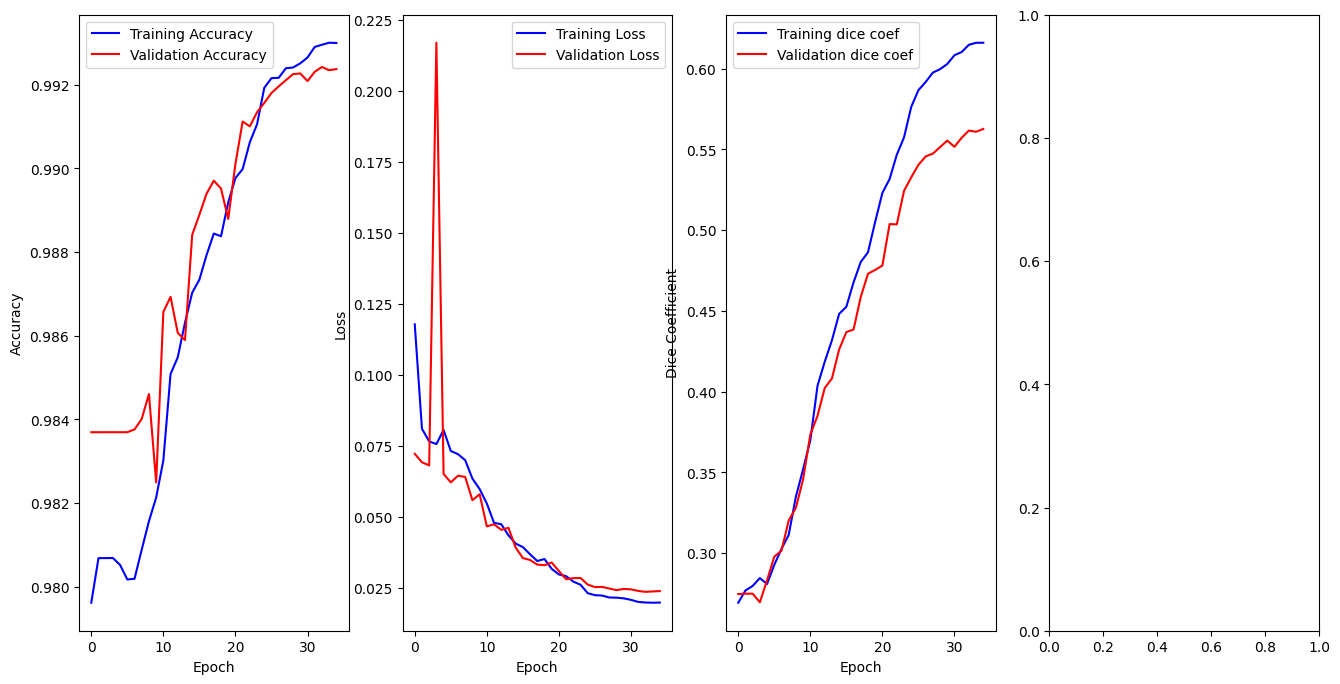

In [ ]:
# Read the CSVlogger file that contains all our metrics (accuracy, loss, dice_coef, ...) of our training
history = pd.read_csv('training.log', sep=',', engine='python')

# Plot training and validation metrics
fig, axs = plt.subplots(1, 4, figsize=(16, 8))

axs[0].plot(history['epoch'], history['accuracy'], 'b', label='Training Accuracy')
axs[0].plot(history['epoch'], history['val_accuracy'], 'r', label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history['epoch'], history['loss'], 'b', label='Training Loss')
axs[1].plot(history['epoch'], history['val_loss'], 'r', label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

axs[2].plot(history['epoch'], history['dice_coef'], 'b', label='Training dice coef')
axs[2].plot(history['epoch'], history['val_dice_coef'], 'r', label='Validation dice coef')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Dice Coefficient')
axs[2].legend()

axs[3].plot(history['epoch'], history['mean_io_u'], 'b', label='Training mean IOU')
axs[3].plot(history['epoch'], history['val_mean_io_u'], 'r', label='Validation mean IOU')
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('Mean IOU')
axs[3].legend()

# Add space between subplots
plt.subplots_adjust(wspace=0.4)

plt.show()

In [ ]:
# Compile a model and load our saved weights
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

best_saved_model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

# best_saved_model.load_weights('model_.26-0.025329.m5')
best_saved_model.load_weights('model_.33-0.023662.m5')

In [ ]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'
    #t1_path = sample_path + '_t1.nii'
    #t2_path = sample_path + '_t2.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X/np.max(X), verbose=1)

In [ ]:
def dice(y_true, y_pred, smooth=1.0):
    class_num = 4
    # for i in range(class_num):
    y_true_f = K.flatten(y_true[:,:])
    y_pred_f = K.flatten(y_pred[:,:])
    y_true_f = tensorflow.cast(y_true_f, tensorflow.float32)
    y_pred_f = tensorflow.cast(y_pred_f, tensorflow.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
    total_loss = loss
    return total_loss

for test_image in samples_test:
    path = os.path.join(data_path, test_image, test_image)
    predicted_seg = predict_segmentation(path)[60, :, :, 0]
    seg_path = path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()
    seg=cv2.resize(seg[:,:,60+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    print(predicted_seg.shape)
    print(seg.shape)
    similarity = dice(seg, predicted_seg)
    print(similarity)

In [ ]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)

    # Get path of this patient
    random_sample_path = os.path.join(data_path, random_sample, random_sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    t1_path = random_sample_path + '_t1.nii'
    t1 = nib.load(t1_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    t1=cv2.resize(t1[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 7, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    axstest[1].imshow(all)
    axstest[1].set_title('Predicted Segmentation - all layers')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - layer 0')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - layer 1')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - layer 2')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - layer 3')

    axstest[6].imshow(t1)
    axstest[6].set_title('Original Image')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

#### Plot Random predictions & Compare with Original (Ground truth)

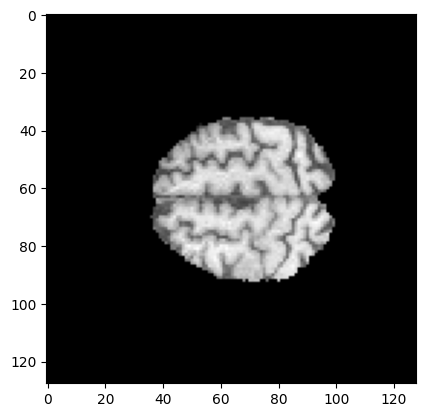

In [ ]:
path = os.path.join(data_path, "BraTS20_Training_011", "BraTS20_Training_011") + '_t1.nii'
img = nib.load(path).get_fdata()
img = cv2.resize(img[:,:,60+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
plt.imshow(img, cmap="gray")

3/3 [==============================] - 0s 48ms/step
Patient number:  BraTS20_Training_011


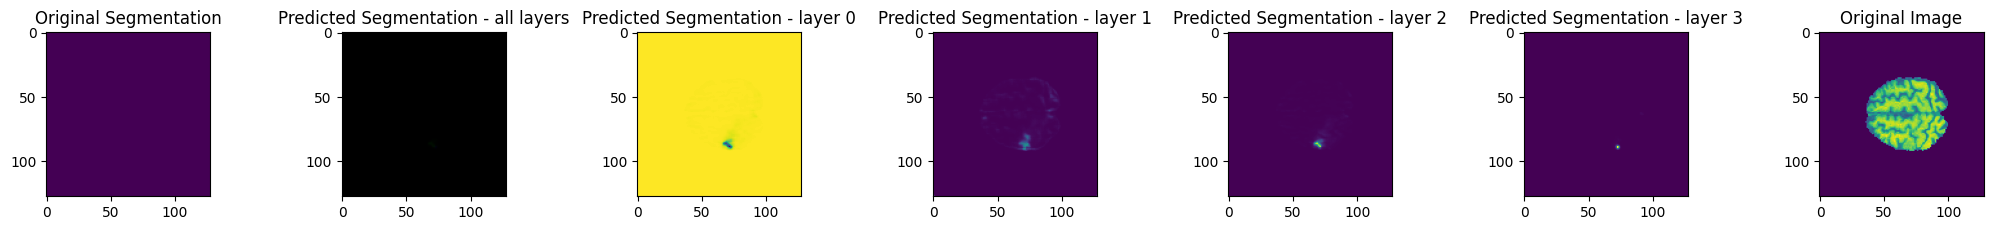

In [ ]:
show_predicted_segmentations(samples_test, 60, cmap, norm)

3/3 [==============================] - 0s 54ms/step
Patient number:  BraTS20_Training_054


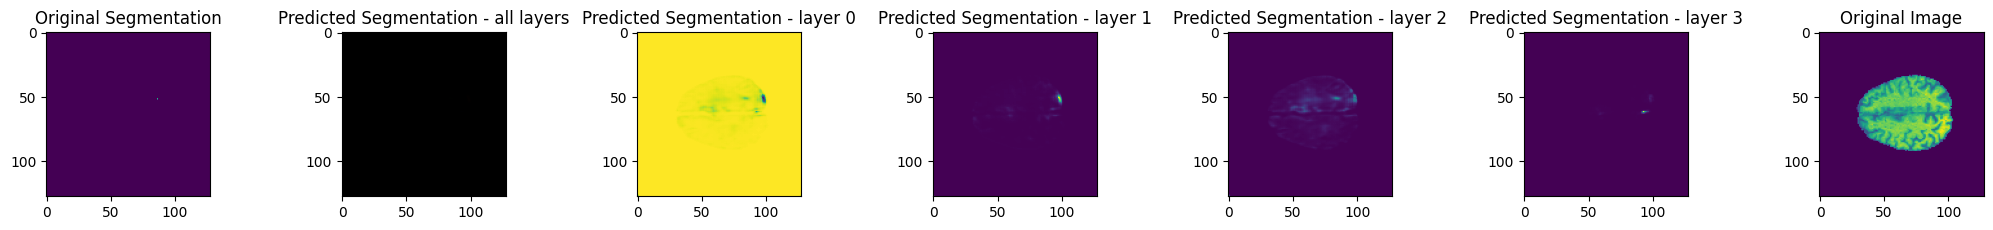

In [ ]:
show_predicted_segmentations(samples_test, 50, cmap, norm)

3/3 [==============================] - 0s 48ms/step
Patient number:  BraTS20_Training_121


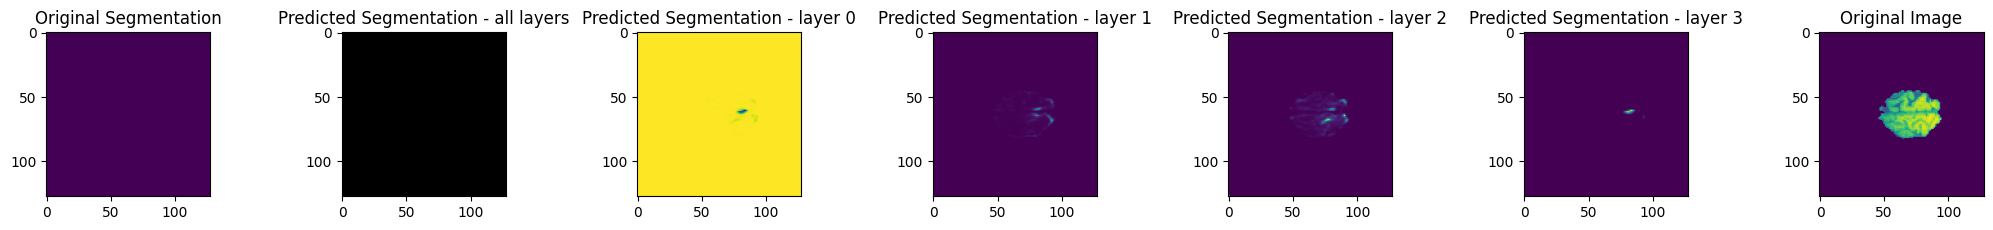

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

3/3 [==============================] - 0s 49ms/step
Patient number:  BraTS20_Training_189


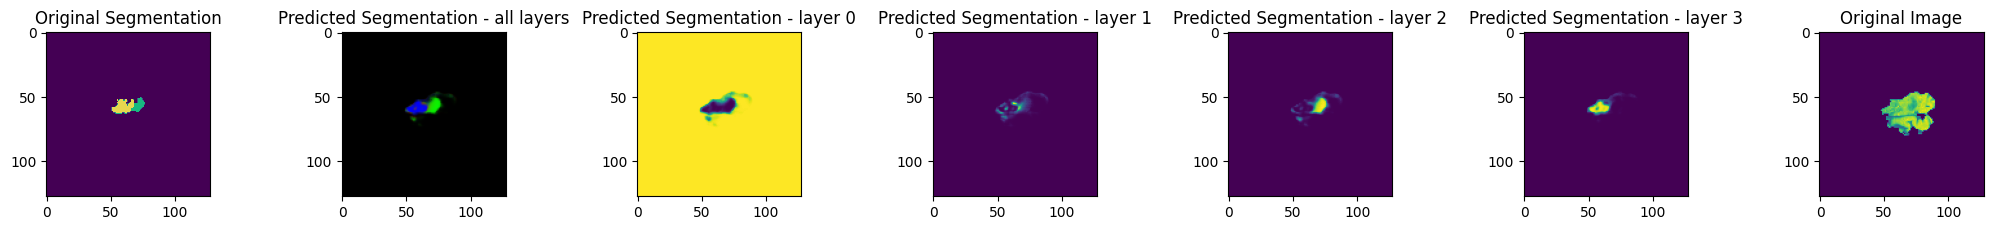

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

3/3 [==============================] - 0s 47ms/step
Patient number:  BraTS20_Training_193


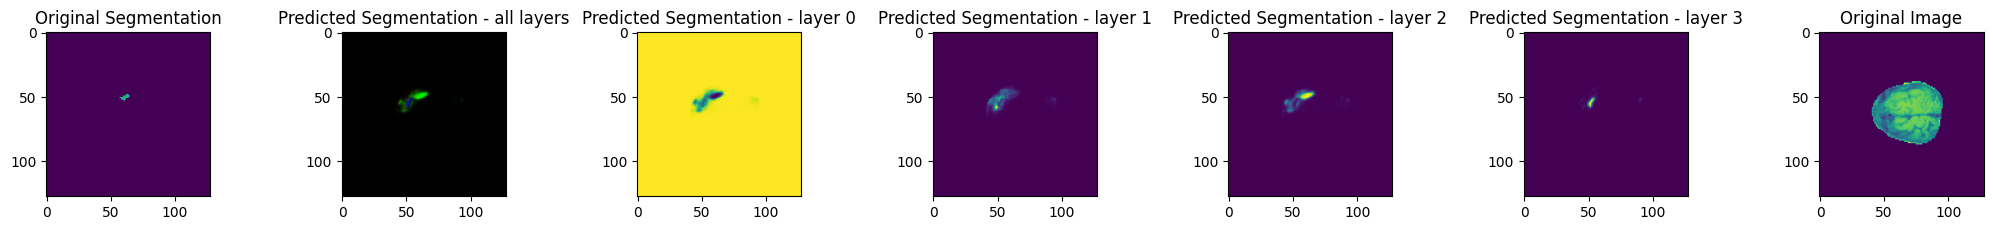

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

#### Post-processing

We are going to use the argmax decoding technique. This process consists in applying the argmax function to obtain a single label for each pixel, corresponding to the class with the highest probability.

In [ ]:
def show_post_processed_segmentations(sample, slice_to_plot, cmap, norm):

    # Get path of this patient
    sample_path = os.path.join(data_path, sample, sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Fix 4 to 3 to have the same values as in the predicted segmentation, and then same colors
    seg[seg==4] = 3

    # Remove background layer (0) from original segmentation
    seg[seg==0] = np.nan

    # Post-processing
    # Get indexes for each class of the highest probability pixels. Array will then contain only [0 1 2 3] instead of probabilities
    my_pred = np.argmax(predicted_seg, axis=3)
    my_pred = my_pred[slice_to_plot, :, :]

    # Remove background layer (0) from post-processed predicted segmentation
    # To fix 0 to np.nan, we need to convert array as a float
    my_pred = my_pred.astype(float)
    my_pred[my_pred == 0] = np.nan

    # Remove background layer (0) from classical predicted segmentation
    all = predicted_seg[slice_to_plot,:,:,1:4]

    # Plot Original segmentation & predicted segmentation without processing & predicted segmentation
    print("Patient number: ", sample)
    fig, axstest = plt.subplots(1, 3, figsize=(15, 10))

    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    axstest[1].imshow(all)
    axstest[1].set_title('Prediction (w/o post processing (layer 1,2,3)')

    axstest[2].imshow(my_pred, cmap, norm)
    axstest[2].set_title('Prediction (w/ post processing (layer 1,2,3)')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

3/3 [==============================] - 0s 72ms/step
Patient number:  BraTS20_Training_266


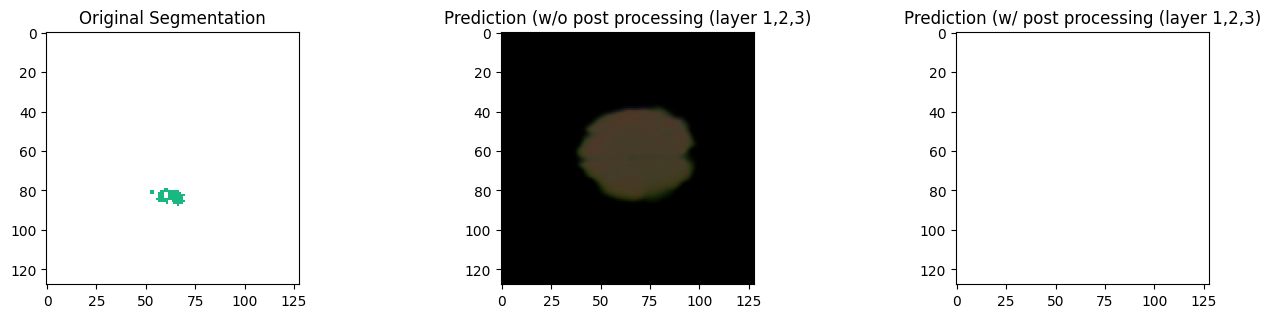

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=60, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 73ms/step
Patient number:  BraTS20_Training_051


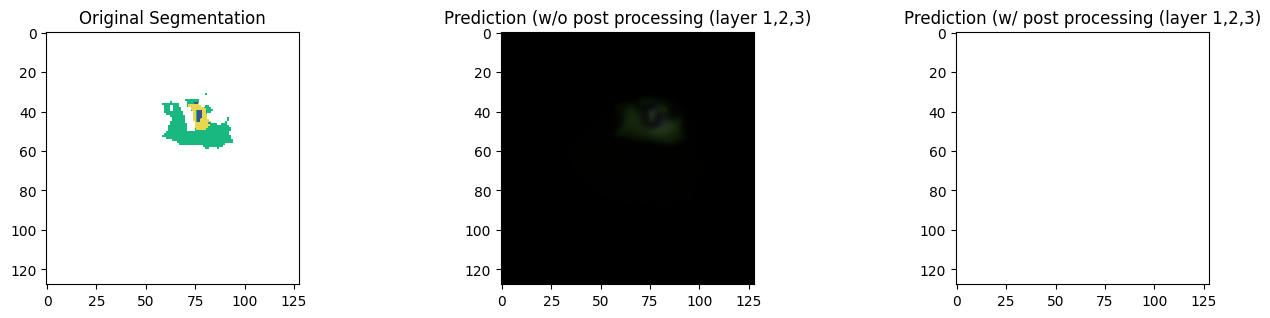

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=50, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 20ms/step
Patient number:  BraTS20_Training_266


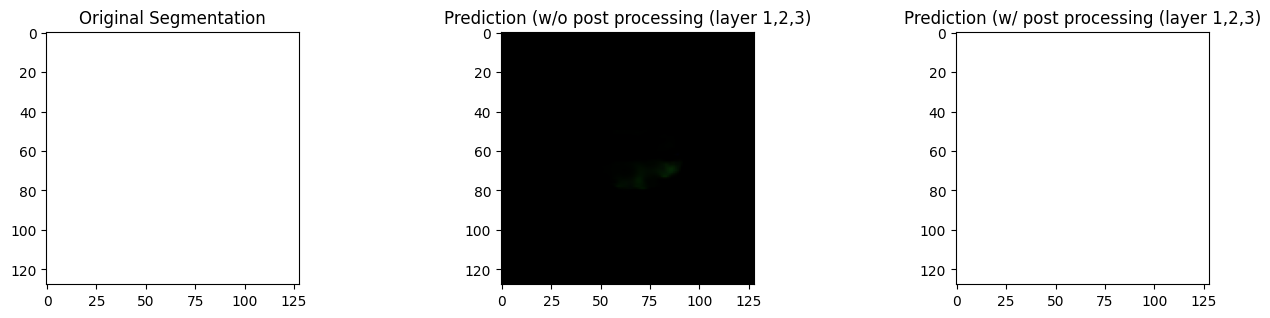

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=70, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 20ms/step
Patient number:  BraTS20_Training_051


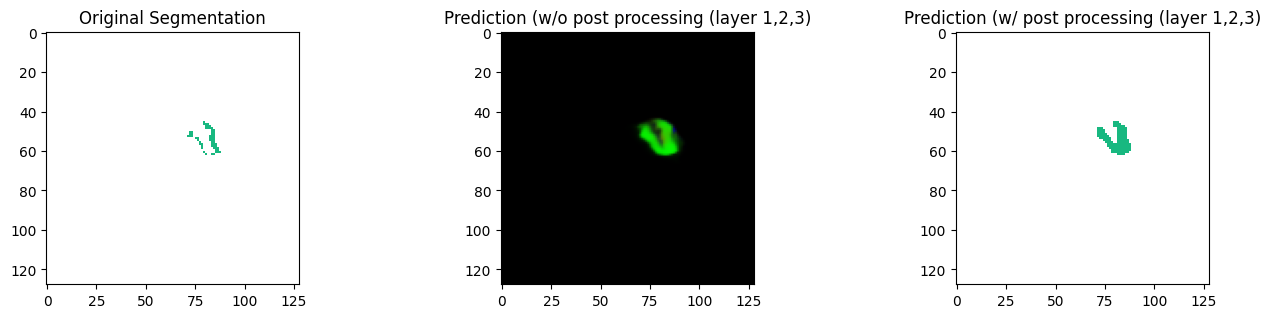

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=70, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 20ms/step
Patient number:  BraTS20_Training_274


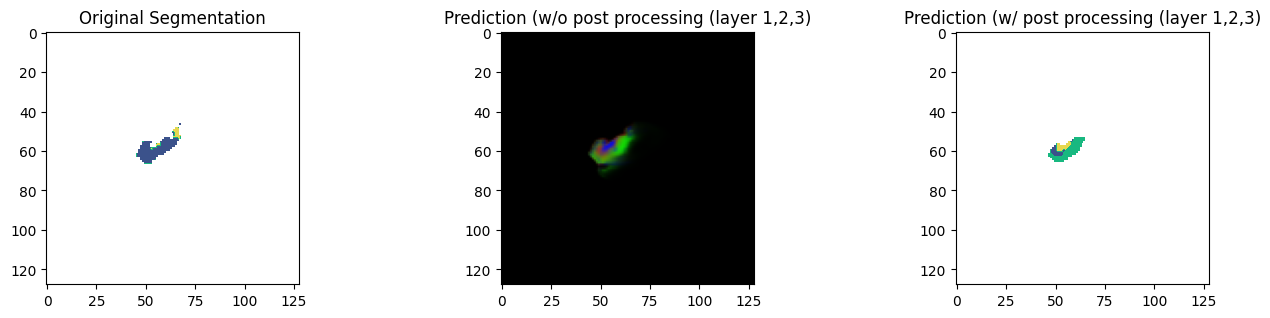

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_274", slice_to_plot=70, cmap=cmap, norm=norm)

Evaluate on test dataset.

In [ ]:
# Evaluate the model on the test data

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

45/45 [==============================] - 28s 589ms/step - loss: 0.0321 - accuracy: 0.9897 - mean_io_u_3: 0.7998 - dice_coef: 0.6004 - precision: 0.9906 - sensitivity: 0.9879 - specificity: 0.9968

Model evaluation on the test set:
Loss : 0.0321
Accuracy : 0.9897
MeanIOU : 0.7998
Dice coefficient : 0.6004
Precision : 0.9906
Sensitivity : 0.9879
Specificity : 0.9968


#### References
- [Article, U-Net Implementation for BraTS 2019 by Naomi Fridman](https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a)

- [Notebook, 3D MRI Brain tumor segmentation, by Rastislav](https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net)

- [The BraTS2020 Challenge](https://www.med.upenn.edu/cbica/brats2020/)

#### Papers
- [Information about the U-Net model, proposed by Ronneberger in 2015](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

- [Advancing The Cancer Genome Atlas glioma MRI collections with expert segmentation labels and radiomic features, Nature Scientific Data, S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J.S. Kirby, et al](https://pubmed.ncbi.nlm.nih.gov/28872634/)

- [Identifying the Best Machine Learning Algorithms for Brain Tumor Segmentation, Progression Assessment, and Overall Survival Prediction in the BRATS Challenge, S. Bakas, M. Reyes, A. Jakab, S. Bauer, M. Rempfler, A. Crimi, et al](https://arxiv.org/abs/1811.02629)

- [The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS), IEEE Transactions on Medical Imaging, B. H. Menze, A. Jakab, S. Bauer, J. Kalpathy-Cramer, K. Farahani, J. Kirby, et al](https://pubmed.ncbi.nlm.nih.gov/25494501/)

#### Sources
- [Image, Image segmentation, Wikipedia Commons](https://commons.wikimedia.org/wiki/File:Image_segmentation.png)

- [Image, Planes of Body, Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Planes_of_Body.jpg)